# Classifying Dogs vs. Cats: Part II
### Notebook by Erika Deckter
This notebook continues the binary classification model example using the Kaggle Dogs vs. Cats image dataset.  Again, the code is adapted from _Deep Learning with Python_ by Francois Chollet.  This code introduces the idea of using pre-trained CNN models to improve the classification for small datasets.

In [1]:
#Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

Using TensorFlow backend.


In [4]:
#Set data directories
base_dir = os.getcwd()+'/data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')                                
train_cats_dir = os.path.join(train_dir, 'cats')                           
train_dogs_dir = os.path.join(train_dir, 'dogs')                       
                                               
validation_dir = os.path.join(base_dir, 'validation') 
validation_cats_dir = os.path.join(validation_dir, 'cats')                                                             
validation_dogs_dir = os.path.join(validation_dir, 'dogs')                 
                                             
test_dir = os.path.join(base_dir, 'test')
test_cats_dir = os.path.join(test_dir, 'cats')                                                                              
test_dogs_dir = os.path.join(test_dir, 'dogs')                        

In [5]:
#Check number of files in each directory
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Using a Pre-Trained CNN

Another way to get improvements in accuracy is to use a CNN that has already been pre-trained on a large set of data, such as ImageNet. We can use just the convolution base of the pre-trained model and throw away the densely connected layers (which are predicting classes or other output that is not consistent with what we want our model to predict.)  

For this model, we will use the VGG16 model, which is included in Keras.  The top (dense) layers in the VGG16 model were used to solve a different classification problem, so we will remove them and replace them with our own top layers for binary dog/cat classification.  This works because detecting low-level features such as edges is the same regardless of the final classification tasks, but the high-level features are specific to each problem being solved.

In [6]:
#Use the VGG16 model, already included with Keras
#Set this model to conv_base variable and throw away the top (densely connected) layers
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

### Extracting Features from Pre-Trained Network
We can run the training, validation and testing image datasets through the VGG16 neural network and extract the output features for each image.  The output of the pre-trained network becomes the input to two dense layers (like the top layers we used in the CNN model we built from scratch).

If we do not include data augmentation, we can do this step only once and reuse the feature set for each image at every epoch.

In [0]:
#Create data generator without data augmentation
datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
#Create function that extracts features and labels for a dataset by batches
def extract_features(directory, sample_count, batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [9]:
#Extract features for training, validation and test datasets
batch = 20
train_features, train_labels = extract_features(train_dir, 2000, batch)
validation_features, validation_labels = extract_features(validation_dir, 1000, batch)
test_features, test_labels = extract_features(test_dir, 1000, batch)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
#Show shape of extracted features and labels
print('Training Features Shape: ', train_features.shape)
print('Training Labels Shape: ', train_labels.shape)
print('Validation Features Shape: ', validation_features.shape)
print('Validation Labels Shape: ', validation_labels.shape)
print('Test Features Shape: ', test_features.shape)
print('Test Labels Shape: ', test_labels.shape)

Training Features Shape:  (2000, 4, 4, 512)
Training Labels Shape:  (2000,)
Validation Features Shape:  (1000, 4, 4, 512)
Validation Labels Shape:  (1000,)
Test Features Shape:  (1000, 4, 4, 512)
Test Labels Shape:  (1000,)


In [11]:
#Flatten features before using them as the input to the densely connected layers.
feature_size = train_features.shape[1]*train_features.shape[2]*train_features.shape[3]

train_features = np.reshape(train_features, (train_features.shape[0], feature_size))
validation_features = np.reshape(validation_features, (validation_features.shape[0], feature_size))
test_features = np.reshape(test_features, (test_features.shape[0], feature_size))

print('Flattened Training Features Shape: ', train_features.shape)
print('Flattened Validation Features Shape: ', validation_features.shape)
print('Flattened Test Features Shape: ', test_features.shape)

Flattened Training Features Shape:  (2000, 8192)
Flattened Validation Features Shape:  (1000, 8192)
Flattened Test Features Shape:  (1000, 8192)


In [0]:
#Function to build dense layers to fit on top of pre-trained VGG16 model
def build_top_layers(learning_rate):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=train_features.shape[1]))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=['acc'])
    
    return model

In [13]:
#Build new model for top layers
learning_rate = 2e-5
pretrained_model = build_top_layers(learning_rate)
pretrained_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Train new top layers using VGG16 extracted features as input
history = pretrained_model.fit(train_features, train_labels,
                                epochs=30,
                                batch_size=20,
                                validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 389us/sample - loss: 0.5666 - acc: 0.6975 - val_loss: 0.4396 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 1s 280us/sample - loss: 0.4273 - acc: 0.8090 - val_loss: 0.3638 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 256us/sample - loss: 0.3592 - acc: 0.8460 - val_loss: 0.3238 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 277us/sample - loss: 0.3149 - acc: 0.8735 - val_loss: 0.3166 - val_acc: 0.8650
Epoch 5/30
2000/2000 [==============================] - 1s 263us/sample - loss: 0.2898 - acc: 0.8780 - val_loss: 0.2858 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 1s 268us/sample - loss: 0.2678 - acc: 0.8900 - val_loss: 0.2773 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 1s 264us/sample - loss: 0.2479 - acc: 0.9015 - val_loss: 0.2711 - va

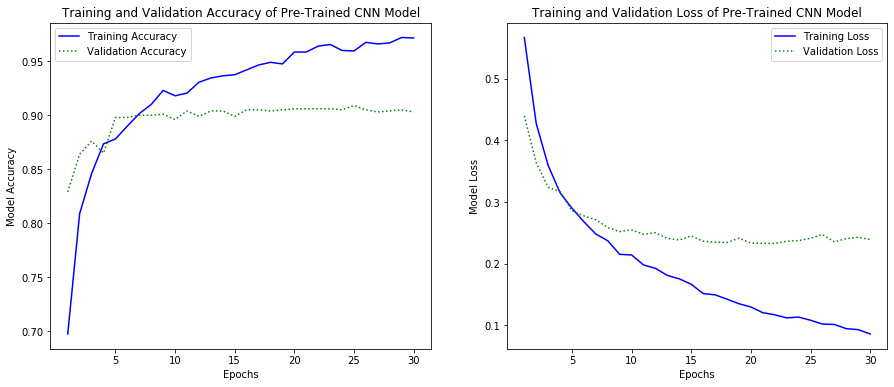

In [15]:
#Plot accuracy and loss for pre-trained model
train_acc = history.history['acc']
validation_acc = history.history['val_acc']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

fig = plt.figure(figsize=(15,6))
#Create accuracy plot
fig.add_subplot(1,2,1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'g:', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Accuracy of Pre-Trained CNN Model')
fig.add_subplot(1,2,2)
#Create loss plot
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'g:', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Loss of Pre-Trained CNN Model') 
plt.show()

In [16]:
#Retrain model 15 epochs to avoid overfitting
pretrained_model = build_top_layers(learning_rate)

pretrained_model.fit(train_features, train_labels,
                     epochs=15,
                     batch_size=20)

Train on 2000 samples
Epoch 1/15
2000/2000 [==============================] - 1s 288us/sample - loss: 0.6151 - acc: 0.6620
Epoch 2/15
2000/2000 [==============================] - 0s 215us/sample - loss: 0.4311 - acc: 0.8050
Epoch 3/15
2000/2000 [==============================] - 0s 213us/sample - loss: 0.3527 - acc: 0.8470
Epoch 4/15
2000/2000 [==============================] - 0s 205us/sample - loss: 0.3161 - acc: 0.8695
Epoch 5/15
2000/2000 [==============================] - 0s 230us/sample - loss: 0.2829 - acc: 0.8870
Epoch 6/15
2000/2000 [==============================] - 0s 222us/sample - loss: 0.2604 - acc: 0.8970
Epoch 7/15
2000/2000 [==============================] - 0s 201us/sample - loss: 0.2417 - acc: 0.9090
Epoch 8/15
2000/2000 [==============================] - 0s 210us/sample - loss: 0.2288 - acc: 0.9145
Epoch 9/15
2000/2000 [==============================] - 0s 210us/sample - loss: 0.2104 - acc: 0.9215
Epoch 10/15
2000/2000 [==============================] - 0s 222us/sam

In [19]:
#Evaluate pre-trained model on test data (to see how it performs on new, unseen data)
test_loss, test_accuracy = pretrained_model.evaluate(test_features, test_labels)
print('Test Loss for Pre-Trained Model: {:.4f}'.format(test_loss))
print('Test Accuracy for Pre-Trained Model: {:.2%}'.format(test_accuracy))

1000/1000 [==============================] - 0s 124us/sample - loss: 0.2587 - acc: 0.8880
Test Loss for Pre-Trained Model: 0.2587
Test Accuracy for Pre-Trained Model: 88.80%


### Data Augmentation with a Pre-Trained CNN Model
In order to use data augmentation, we need to feed the augmented images into the full network (including the convolution base).  This requires more compute power, but should generate even more accurate results.

In [20]:
#Create image generator with data augmentation parameters for training data
#Note: Transformations should NOT be performed on validation/test data
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Create generator
train_augmented_generator = train_datagen_augmented.flow_from_directory(
        train_dir,                                             
        target_size=(150, 150), #Resize image to 150x150
        batch_size=20, #Set each batch to contain 20 cute dogs or cats
        class_mode='binary') #Assign a binary class (cat or dog)

#Build data generator for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
#Build top layers on top of convolution base from VGG model
def build_pretrained_model(learning_rate):
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    #Freeze convolution base weights
    conv_base.trainable = False
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=learning_rate),
                  metrics=['acc'])
    
    return model

In [34]:
learning_rate = 2e-5
final_model = build_pretrained_model(learning_rate)
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
#Train model using pre-trained VGG16 and data augmentation
history = final_model.fit_generator(train_augmented_generator,
                                    steps_per_epoch=100,
                                    epochs=30,
                                    validation_data=validation_generator,
                                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 23s 226ms/step - loss: 0.3942 - acc: 0.8565 - val_loss: 0.2213 - val_acc: 0.9160
Epoch 2/30
100/100 [==============================] - 22s 217ms/step - loss: 0.2045 - acc: 0.9395 - val_loss: 0.1897 - val_acc: 0.9170
Epoch 3/30
100/100 [==============================] - 21s 212ms/step - loss: 0.1482 - acc: 0.9640 - val_loss: 0.1656 - val_acc: 0.9260
Epoch 4/30
100/100 [==============================] - 21s 213ms/step - loss: 0.1177 - acc: 0.9660 - val_loss: 0.1598 - val_acc: 0.9300
Epoch 5/30
100/100 [==============================] - 21s 213ms/step - loss: 0.1112 - acc: 0.9575 - val_loss: 0.1614 - val_acc: 0.9320
Epoch 6/30
100/100 [==============================] - 21s 207ms/step - loss: 0.0942 - acc: 0.9715 - val_loss: 0.1646 - val_acc: 0.9300
Epoch 7/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0874 - acc: 0.9735 - val_loss: 0.1713 - val_acc: 0.9270
Epoch 8/30
100/100 [==============================] - 2

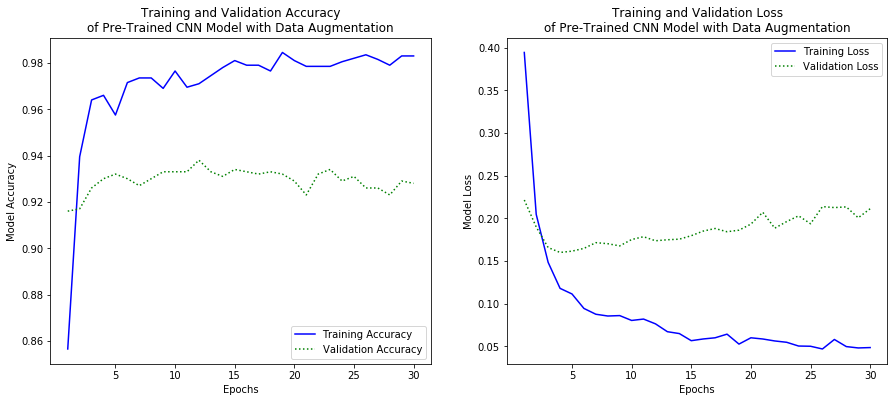

In [36]:
#Plot accuracy and loss for pre-trained model with data augmentation
train_acc = history.history['acc']
validation_acc = history.history['val_acc']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

fig = plt.figure(figsize=(15,6))
#Create accuracy plot
fig.add_subplot(1,2,1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'g:', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Accuracy\nof Pre-Trained CNN Model with Data Augmentation')
fig.add_subplot(1,2,2)
#Create loss plot
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'g:', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Loss\nof Pre-Trained CNN Model with Data Augmentation') 
plt.show()

In [37]:
#Evaluate pre-trained model on test data with data augmentation
test_loss, test_accuracy = final_model.evaluate_generator(test_generator, steps=50)
print('Test Loss for Pre-Trained Model with Data Augmentation: {:.4f}'.format(test_loss))
print('Test Accuracy for Pre-Trained Model with Data Augmentation: {:.2%}'.format(test_accuracy))

Test Loss for Pre-Trained Model with Data Augmentation: 0.2458
Test Accuracy for Pre-Trained Model with Data Augmentation: 92.80%


### Fine-Tuning Convolution Base Weights
In order to further improve the accuracy of the model, we can fine-tune the weights of the last block (block 5) of the convolution base.  This is done by unfreezing the weights of the top block *after* the top layers have already been trained and then continuing to train the model.  This doesn't undo the pre-training because the initial weights of the top layers are no longer random (they are pretty close to their final weights).  

For this, we will need to recompile the model, but we will not want to rebuild the model from scratch.

In [38]:
#Unfreeze layers in block 5
conv_base.trainable = True

for layer in conv_base.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
    print('Layer {:s} is now trainable. {:}'.format(layer.name, layer.trainable))

Layer input_1 is now trainable. False
Layer block1_conv1 is now trainable. False
Layer block1_conv2 is now trainable. False
Layer block1_pool is now trainable. False
Layer block2_conv1 is now trainable. False
Layer block2_conv2 is now trainable. False
Layer block2_pool is now trainable. False
Layer block3_conv1 is now trainable. False
Layer block3_conv2 is now trainable. False
Layer block3_conv3 is now trainable. False
Layer block3_pool is now trainable. False
Layer block4_conv1 is now trainable. False
Layer block4_conv2 is now trainable. False
Layer block4_conv3 is now trainable. False
Layer block4_pool is now trainable. False
Layer block5_conv1 is now trainable. True
Layer block5_conv2 is now trainable. True
Layer block5_conv3 is now trainable. True
Layer block5_pool is now trainable. True


In [39]:
#Recompile model
learning_rate = 1e-5
final_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=learning_rate),
                    metrics=['acc'])

#Review summary and notice there are now more trainable layers
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [40]:
#Continue to train model to perform fine-tuning
history = final_model.fit_generator(train_augmented_generator,
                                    steps_per_epoch=100,
                                    epochs=50,
                                    validation_data=validation_generator,
                                    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 23s 235ms/step - loss: 0.0737 - acc: 0.9735 - val_loss: 0.2075 - val_acc: 0.9300
Epoch 2/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0631 - acc: 0.9770 - val_loss: 0.2360 - val_acc: 0.9290
Epoch 3/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0619 - acc: 0.9780 - val_loss: 0.2124 - val_acc: 0.9340
Epoch 4/50
100/100 [==============================] - 21s 213ms/step - loss: 0.0657 - acc: 0.9790 - val_loss: 0.2337 - val_acc: 0.9230
Epoch 5/50
100/100 [==============================] - 22s 215ms/step - loss: 0.0634 - acc: 0.9790 - val_loss: 0.2538 - val_acc: 0.9280
Epoch 6/50
100/100 [==============================] - 22s 215ms/step - loss: 0.0586 - acc: 0.9770 - val_loss: 0.2091 - val_acc: 0.9390
Epoch 7/50
100/100 [==============================] - 21s 213ms/step - loss: 0.0689 - acc: 0.9725 - val_loss: 0.2620 - val_acc: 0.9250
Epoch 8/50
100/100 [==============================] - 2

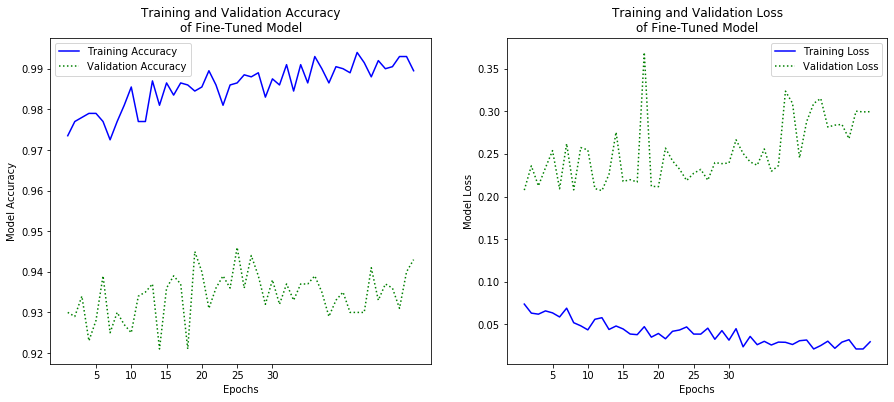

In [41]:
#Plot accuracy and loss for fine-tuned model with data augmentation
train_acc = history.history['acc']
validation_acc = history.history['val_acc']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

fig = plt.figure(figsize=(15,6))
#Create accuracy plot
fig.add_subplot(1,2,1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_acc, 'g:', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Accuracy\nof Fine-Tuned Model')
fig.add_subplot(1,2,2)
#Create loss plot
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'g:', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.xticks([5,10,15,20,25,30])
plt.title('Training and Validation Loss\nof Fine-Tuned Model') 
plt.show()

In [42]:
#Evaluate pre-trained model on test data after fine tuning
test_loss, test_accuracy = final_model.evaluate_generator(test_generator, steps=50)
print('Test Loss for Pre-Trained Model with Data Augmentation and Fine Tuning: {:.4f}'.format(test_loss))
print('Test Accuracy for Pre-Trained Model with Data Augmentation and Fine Tuning: {:.2%}'.format(test_accuracy))

Test Loss for Pre-Trained Model with Data Augmentation and Fine Tuning: 0.3658
Test Accuracy for Pre-Trained Model with Data Augmentation and Fine Tuning: 93.10%
